<hr/>

# Foundations of Reinforcement Learning

<hr/>

<h1><font color="darkblue">Lab 5: SARSA and Q-learning  </font></h1>



<!-- ## Deadline
11:59 pm Nov 6th, 2020  -->

##  Content
1. Cliff walking example
2. Car pole example



Import Gym and other necessary libraries

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython import display
import random

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Cliff walk example

### 1.1 Intro to Cliff walk 

In this section, we use SARSA and Q-learning algorithm to solve to a cliff walk problem. ( See Sutton&Barto Example 6.6 )

The grid is shown below, the black tiles represents wall/obstacles, the white tiles are the non-terminal tiles, and the tile with "s" is the starting point of every episoid, the tile with "G" is the goal point.

The agent start at "s" tile. At every step, the agent can choose one of the four actions:"up","right","down","left", moving to the next tile in that direction. 

$\cdot$ If the next tile is wall/obstacle, the agent does not move and receive -1 reward;

$\cdot$ If the next tile is a non-terminal tile, the agent move to that tile and receive 0 reward;

$\cdot$ If the next tile is the goal tile, the episoid is finished and the agent receive 100 reward (set to be 100 to accelarate the training).

$\cdot$ If the next tile is the cliff, the episoid is finished and the agent receive -100 reward ;

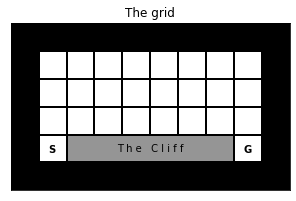

In [2]:
from gridworld2 import GridWorld

gw = GridWorld()
gw.plot_grid(plot_title='The grid')

### 1.1.1 States and state values
Excluding the wall around the grid, there are 32 tiles (INCLUDING obstacles inside the grid), and they correspond to 32 states (obstacles and goal are non-reachable states).

We use numbers from 0 to 24 to represent these states (see gridworld.py for the coversion between integer and tile position). The correspondance are as shown below:

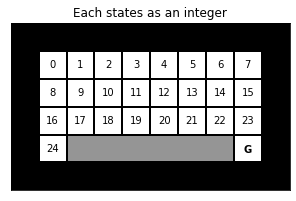

In [3]:
gw.plot_state_values(np.arange(25),value_format="{:d}",plot_title='Each states as an integer')

### 1.1.2 Take actions
Use GridWorld.step(action) to take an action, and use GridWorld.reset() to restart an episoid

action is an integer from 0 to 3

0: "Up"; 1: "Right"; 2: "Down"; 3: "Left" 

In [4]:
gw.reset()

current_state = gw.get_current_state()
tile_pos = gw.int_to_state(current_state)

print("The current state is {}, which corresponds to tile position {}\n".format(current_state,tile_pos))

action = np.random.randint(4)
reward, terminated, next_state = gw.step(action)
tile_pos = gw.int_to_state(next_state)

print("Take action {}, get reward {}, move to state {}".format(action,reward,next_state))
print("Now the current state is {}, which corresponds to tile position {}\n".format(next_state,tile_pos))

gw.reset()
current_state = gw.get_current_state()
tile_pos = gw.int_to_state(current_state)
print("Reset episode")
print("Now the current state is {}, which corresponds to tile position {}".format(current_state,tile_pos))



The current state is 24, which corresponds to tile position (3, 0)

Take action 0, get reward -1.0, move to state 16
Now the current state is 16, which corresponds to tile position (2, 0)

Reset episode
Now the current state is 24, which corresponds to tile position (3, 0)


### 1.1.3 Plot Deterministic Policies
A deterministic policy is a function from state to action, which can be represented by a (32,)-numpy array whose entries are all integers in (0-3)

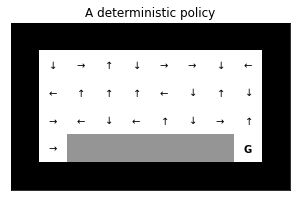

In [5]:
gw.plot_policy(np.random.randint(4,size=(32,)),plot_title='A deterministic policy')

### 1.2 SARSA & Q_learning

1. Implement SARSA algorithm (See Sutton&Barto Section 6.4) on this example for 5000 episodes to learn the optimal policy. 
   Plot the greedy policy of the learned Q-function using gw.plot_policy()

0. Implement Q_learning algorithm (See Sutton&Barto Section 6.5) on this example for 5000 episodes to learn the optimal policy. 
   Plot the greedy policy of the learned Q-function using gw.plot_policy()
0. Plot the total rewards during one episode v.s. number of episodes trained for both SARSA and Q-Learning. Compare the plot to [Sutton & Barto Figure 6.4] (Optional)You may  [1]. Smooth your curve by taking the average of total rewards over successive 50 episodes [2].Avoid adding the artificial "+100" goal reward to the total reward to match you figure with the book (Although we need to used goal reward when update the Q-function )


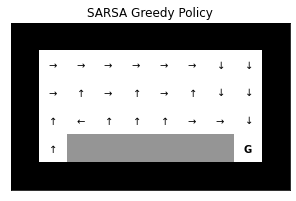

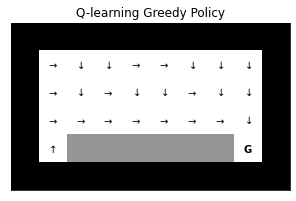

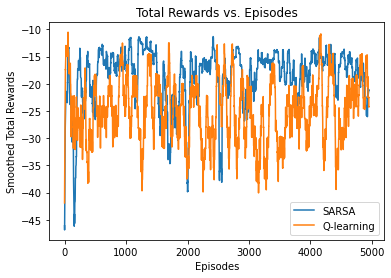

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from gridworld2 import GridWorld

gw = GridWorld()


def update_Q(Q, current_idx, next_idx, current_action, next_action, alpha, R, gamma):
    # Update Q at each step
    Q[current_idx, current_action] = Q[current_idx, current_action] + alpha * (R + gamma * Q[next_idx, next_action] - Q[current_idx, current_action])
    return Q

def get_action(current_idx, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(4)  # Random action with epsilon probability
    else:
        return np.argmax(Q[current_idx])  # Greedy action based on Q-values

# SARSA
Q_sarsa = np.zeros((25, 4))
gw.reset()

max_ep = 5000
total_reward_sarsa = np.zeros(max_ep)

epsilon = 0.1
alpha = 0.5
gamma = 0.9

for ep in range(0, max_ep):
    gw.reset()
    terminated = False
    current_state = gw.get_current_state()
    current_action = get_action(current_state, Q_sarsa, epsilon)
    total_reward_sarsa[ep] = 0

    while not terminated:
        reward, terminated, next_state = gw.step(current_action)
        if reward != 100:
            total_reward_sarsa[ep] += reward
        next_action = get_action(next_state, Q_sarsa, epsilon)
        Q_sarsa = update_Q(Q_sarsa, current_state, next_state, current_action, next_action, alpha, reward, gamma)
        current_state = next_state
        current_action = next_action

# Q-learning
Q_q_learning = np.zeros((25, 4))
gw.reset()

max_ep = 5000
total_reward_q_learning = np.zeros(max_ep)

epsilon = 0.1
alpha = 0.5
gamma = 0.9

for ep in range(0, max_ep):
    gw.reset()
    terminated = False
    current_state = gw.get_current_state()
    total_reward_q_learning[ep] = 0

    while not terminated:
        current_action = get_action(current_state, Q_q_learning, epsilon)
        reward, terminated, next_state = gw.step(current_action)
        if reward != 100:
            total_reward_q_learning[ep] += reward
        best_next_action = np.argmax(Q_q_learning[next_state])
        Q_q_learning = update_Q(Q_q_learning, current_state, next_state, current_action, best_next_action, alpha, reward, gamma)
        current_state = next_state

# Plot the greedy policy for SARSA and Q-learning
gw.plot_policy(np.argmax(Q_sarsa, axis=1))
plt.title("SARSA Greedy Policy")
plt.show()

gw.plot_policy(np.argmax(Q_q_learning, axis=1))
plt.title("Q-learning Greedy Policy")
plt.show()

# Plot the total rewards
def smooth_rewards(rewards, window_size):
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    return smoothed_rewards

window_size = 50
smoothed_sarsa_rewards = smooth_rewards(total_reward_sarsa, window_size)
smoothed_q_learning_rewards = smooth_rewards(total_reward_q_learning, window_size)

plt.plot(smoothed_sarsa_rewards, label="SARSA")
plt.plot(smoothed_q_learning_rewards, label="Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Total Rewards")
plt.legend()
plt.title("Total Rewards vs. Episodes")
plt.show()


Total reward removed

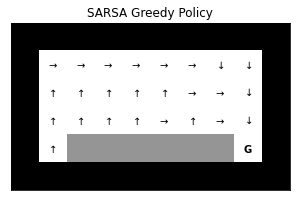

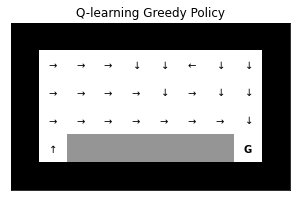

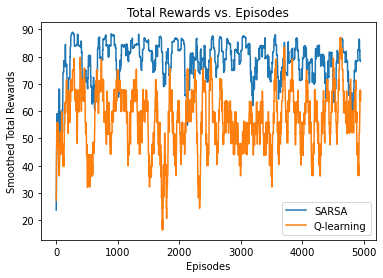

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from gridworld2 import GridWorld

gw = GridWorld()


def update_Q(Q, current_idx, next_idx, current_action, next_action, alpha, R, gamma):
    # Update Q at each step
    Q[current_idx, current_action] = Q[current_idx, current_action] + alpha * (R + gamma * Q[next_idx, next_action] - Q[current_idx, current_action])
    return Q

def get_action(current_idx, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(4)  # Random action with epsilon probability
    else:
        return np.argmax(Q[current_idx])  # Greedy action based on Q-values

# SARSA
Q_sarsa = np.zeros((25, 4))
gw.reset()

max_ep = 5000
total_reward_sarsa = np.zeros(max_ep)

epsilon = 0.1
alpha = 0.5
gamma = 0.9

for ep in range(0, max_ep):
    gw.reset()
    terminated = False
    current_state = gw.get_current_state()
    current_action = get_action(current_state, Q_sarsa, epsilon)
    total_reward_sarsa[ep] = 0

    while not terminated:
        reward, terminated, next_state = gw.step(current_action)
        
        total_reward_sarsa[ep] += reward
        next_action = get_action(next_state, Q_sarsa, epsilon)
        Q_sarsa = update_Q(Q_sarsa, current_state, next_state, current_action, next_action, alpha, reward, gamma)
        current_state = next_state
        current_action = next_action

# Q-learning
Q_q_learning = np.zeros((25, 4))
gw.reset()

max_ep = 5000
total_reward_q_learning = np.zeros(max_ep)

epsilon = 0.1
alpha = 0.5
gamma = 0.9

for ep in range(0, max_ep):
    gw.reset()
    terminated = False
    current_state = gw.get_current_state()
    total_reward_q_learning[ep] = 0

    while not terminated:
        current_action = get_action(current_state, Q_q_learning, epsilon)
        reward, terminated, next_state = gw.step(current_action)
        
        total_reward_q_learning[ep] += reward
        best_next_action = np.argmax(Q_q_learning[next_state])
        Q_q_learning = update_Q(Q_q_learning, current_state, next_state, current_action, best_next_action, alpha, reward, gamma)
        current_state = next_state

# Plot the greedy policy for SARSA and Q-learning
gw.plot_policy(np.argmax(Q_sarsa, axis=1))
plt.title("SARSA Greedy Policy")
plt.show()

gw.plot_policy(np.argmax(Q_q_learning, axis=1))
plt.title("Q-learning Greedy Policy")
plt.show()

# Plot the total rewards
def smooth_rewards(rewards, window_size):
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    return smoothed_rewards

window_size = 50
smoothed_sarsa_rewards = smooth_rewards(total_reward_sarsa, window_size)
smoothed_q_learning_rewards = smooth_rewards(total_reward_q_learning, window_size)

plt.plot(smoothed_sarsa_rewards, label="SARSA")
plt.plot(smoothed_q_learning_rewards, label="Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Total Rewards")
plt.legend()
plt.title("Total Rewards vs. Episodes")
plt.show()


## 2. CartPole-v1 

### 2.1 CartPole Introduction

We now use SARSA and Q-learning to the CartPole problem. 


1. A pole is attached via an un-actuated joint to a cart, which moves along a frictionless track. 

0. The system is controlled by applying a force of +1 or -1 to the cart. 

0. The pole starts at upright position, and the goal is to prevent it from falling over. 

0. A reward of +1 is obtained for every timestep that the pole remains upright. 

0. The episode ends when the pole is more than 15 degrees from the vertical, or the cart moves more than 2.4 units from the center.

0. For more info (See [SOURCE ON GITHUB](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)).

The following examples show the basic usage of this testing environment: 



### 2.1.1 Episode initialization and Initial Value

In [7]:
env = gym.make('CartPole-v0')
observation = env.reset() ##Initial an episode

if gym.__version__>'0.26.0':
    observation = observation[0]

print("Inital observation is {}".format(observation))

print("\nThis means the cart current position is {}".format(observation[0]), end = '')
print(" with velocity {},".format(observation[1]))

print("and the pole current angular position is {}".format(observation[2]), end = '')
print(" with angular velocity {},".format(observation[3]))


Inital observation is [-0.02385376 -0.01577314 -0.03481017  0.00602186]

This means the cart current position is -0.023853756487369537 with velocity -0.015773141756653786,
and the pole current angular position is -0.03481016680598259 with angular velocity 0.00602186331525445,


### 2.1.2 Take actions


Use env.step(action) to take an action

action is an integer from 0 to 1

0: "Left"; 1: "Right"

In [8]:
print("Current observation is {}".format(observation))

action = 0 #go left

if gym.__version__>'0.26.0':
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
else:
    observation, reward, done, info = env.step(action) # simulate one step



print("\nNew observation is {}".format(observation))
print("Step reward is {}".format(reward))
print("Did episode just ends? -{}".format(done)) # episode ends when 3.1(6) happens

Current observation is [-0.02385376 -0.01577314 -0.03481017  0.00602186]

New observation is [-0.02416922 -0.21037902 -0.03468973  0.28752172]
Step reward is 1.0
Did episode just ends? -False


### 2.1.3 Simulate multiple episodes

(You may uncomment those lines to see an animation. However, it will not work for JupyterHub since the animation requires GL instead of webGL. If you have Jupyter notebook localy on your computer, this version of code will work through a virtual frame.)

In [9]:
env = gym.make('CartPole-v0')
observation = env.reset()
total_reward = 0
ep_num = 0
# img = plt.imshow(env.render(mode='rgb_array')) 


for _ in range(1000):
    #     img.set_data(env.render(mode='rgb_array')) 
    #     display.display(plt.gcf())
    #     display.clear_output(wait=True)
    
    action = env.action_space.sample()     # this takes random actions
    #################### simulate one step
    if gym.__version__>'0.26.0':
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    else:
        observation, reward, done, info = env.step(action) 
    ####################
       
    total_reward += reward
    


    if done:                               # episode just ends
        observation = env.reset()          # reset episode
        if gym.__version__>'0.26.0':
            observation = observation[0]
        ep_num += 1

print("Average reward per episode is {}".format(total_reward/ep_num))
env.close()


Average reward per episode is 25.641025641025642


C:\Users\rprikhodko\Anaconda4\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\rprikhodko\Anaconda4\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### 2.1.4 States Discretization 

The class DiscreteObs() discretizes the observation space into discrete state space, based on numpy.digitize (Please read its description in https://numpy.org/doc/stable/reference/generated/numpy.digitize.html) 

Discretization of observation space is necessary for tabular methods. You can use DiscreteObs() or any other library for discretizing the observation space. 

In [3]:
class DiscretObs():
    
    
    def __init__(self, bins_list):
        self._bins_list = bins_list
        
        self._bins_num = len(bins_list)
        self._state_num_list = [len(bins)+1 for bins in bins_list]
        self._state_num_total = np.prod(self._state_num_list)
    
    def get_state_num_total(self):
        
        return self._state_num_total
    
    def _state_num_list(self):
        
        return self._state_num_list
    
    def obs2state(self, obs):
        
        if not len(obs)==self._bins_num:
            raise ValueError("observation must have length {}".format(self._bins_num))
        else:
            return [np.digitize(obs[i], bins=self._bins_list[i]) for i in range(self._bins_num)]
        
    def obs2idx(self, obs):
        
        state = self.obs2state(obs)
        
        return self.state2idx(state)
    
    def state2idx(self, state):
        
        idx = 0
        for i in range(self._bins_num-1,-1,-1):
            idx = idx*self._state_num_list[i]+state[i]
        
        return idx
    
    def idx2state(self, idx):
        
        state = [None]*self._bins_num
        state_num_cumul = np.cumprod(self._state_num_list)
        for i in range(self._bins_num-1,0,-1):
            state[i] = idx//state_num_cumul[i-1]
            idx -=state[i]*state_num_cumul[i-1]
        state[0] = idx%state_num_cumul[0]
        
        return state

# Recommended epsilon and learning_rate update (Feel free to modify existing and add new functions)
def get_epsilon(t):
    return max(0.1, min(1., 1. - math.log10((t + 1) / 25)))

def get_learning_rate(t):
    return max(0.1, min(1., 1. - math.log10((t + 1) / 25)))



# Recommended Discretization for Carpole-v1 when using Monte-Carlo methods
bins_pos = []                                       # position
bins_d_pos = []                                     # velocity
bins_ang = np.linspace(-0.41887903,0.41887903,5)    # angle
bins_d_ang = np.linspace(-0.87266,0.87266,11)       # angular velocity

dobs = DiscretObs([bins_pos,bins_d_pos,bins_ang,bins_d_ang])
observation = env.reset()
if gym.__version__>'0.26.0':
    observation = observation[0]
state = dobs.obs2state(observation)

idx = dobs.state2idx(state)


print("Current position of the cart is {:.4f}\n".format(observation[0]))
print("Current velocity of the cart is {:.4f}\n".format(observation[1]))
print("Current angular position of the pole is {:.4f} rad\n".format(observation[2]))
print("Current angular velocity of the pole is {:.4f} rad\n".format(observation[3]))

print("which are mapped to state {}, with corresponding index {}".format(state,idx))
print("index {} maps to state{}".format(idx,dobs.idx2state(idx)))


Current position of the cart is 0.0378

Current velocity of the cart is -0.0477

Current angular position of the pole is 0.0085 rad

Current angular velocity of the pole is -0.0135 rad

which are mapped to state [0, 0, 3, 5], with corresponding index 33
index 33 maps to state[0, 0, 3, 5]


### 2.2 SARSA & Q_learning

1. Implement SARSA algorithm (See Sutton&Barto Section 6.4) on this example for 1000 episodes to learn the optimal policy. 

0. Divide the 1000 traing episodes into 50 sets. Plot the average reward for each set. (i.e. plot the average reward for the first 20 episodes, the second 20 episodes, ..., and the 50th 20 episodes.) 

0. Implement Q_learning algorithm (See Sutton&Barto Section 6.5) on this example for 1000 episodes to to learn the optimal policy.

0. Divide the 1000 traing episodes into 50 sets. Plot the average reward for each set. (i.e. plot the average reward for the first 20 episodes, the second 20 episodes, ..., and the 50th 20 episodes.) 



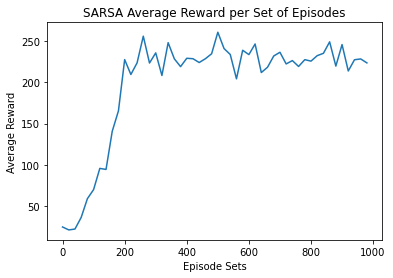

In [42]:
import numpy as np
import gym
import matplotlib.pyplot as plt

def update_Q(Q, current_idx, next_idx, current_action, next_action, alpha, R, gamma):
    Q[current_idx, current_action] = Q[current_idx, current_action] + alpha * (R + gamma * Q[next_idx, next_action] 
                                                                                   - Q[current_idx, current_action])
    return Q

# Define the get_action function
def get_action(current_state, Q, epsilon):
    if np.random.rand() < epsilon:
        # Randomly select an action
        action = env.action_space.sample() 
        return action
    else:
        # Choose the action with the highest Q-value for the current state
        return np.argmax(Q[current_state, :])


def get_learning_rate(episode):
    return max(0.01, min(1.0, 1.0 - np.log10((episode + 1) / 25)))

def get_epsilon(episode):
    return max(0.01, min(1, 1.0 - np.log10((episode + 1) / 25)))




# Number of sets for plotting
set_num = 50

# Initialize Q-table
num_actions = env.action_space.n
state_space_size = [env.observation_space.high[0], 2.0, env.observation_space.high[2], 4.0]

Q = np.zeros((dobs.get_state_num_total(),num_actions))
             

results = np.zeros(set_num)
s = 0

gamma = 0.98

for ep in range(1000):
    if np.mod(ep, 20) == 0:
        results[s] = total_reward / 20
        s += 1
        total_reward = 0

    observation = env.reset()
    if gym.__version__>'0.26.0': observation = observation[0]
    current_state = dobs.obs2state(observation)
    current_idx = dobs.state2idx(current_state)

    alpha = get_learning_rate(ep)
    epsilon = get_epsilon(ep)

    done = False

    while not done:
        total_reward += 1
        action = get_action(current_idx, Q, epsilon)
        if gym.__version__>'0.26.0': observation = observation[0]
      
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        next_state =  dobs.obs2state(observation)
        next_idx =dobs.state2idx(next_state )
        next_action = get_action(next_idx, Q, epsilon)

        Q = update_Q(Q, current_idx, next_idx, action, next_action, alpha, reward, gamma)

        current_idx = next_idx

    if s >= set_num:
        break



# Plot the average reward for each set of 20 episodes
episode_sets = np.arange(0, 1000, 20)
plt.plot(episode_sets, results)
plt.xlabel('Episode Sets')
plt.ylabel('Average Reward')
plt.title('SARSA Average Reward per Set of Episodes')
plt.show()


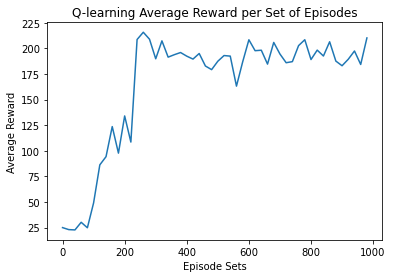

In [39]:
import numpy as np
import gym
import matplotlib.pyplot as plt


def update_Q(Q, current_idx, next_idx, current_action, alpha, R, gamma):
    best_next_action = np.argmax(Q[next_idx, :])
    Q[current_idx, current_action] = Q[current_idx, current_action] + alpha * (R + gamma * Q[next_idx, best_next_action] - Q[current_idx, current_action])
    return Q

# Define the get_action function
def get_action(current_state, Q, epsilon):
    if np.random.rand() < epsilon:
        # Randomly select an action
        action = env.action_space.sample() 
        return action
    else:
        # Choose the action with the highest Q-value for the current state
        return np.argmax(Q[current_state, :])


def get_learning_rate(episode):
    return max(0.01, min(1.0, 1.0 - np.log10((episode + 1) / 25)))

def get_epsilon(episode):
    return max(0.01, min(1, 1.0 - np.log10((episode + 1) / 25)))




# Number of sets for plotting
set_num = 50

# Initialize Q-table
num_actions = env.action_space.n
state_space_size = [env.observation_space.high[0], 2.0, env.observation_space.high[2], 4.0]

Q = np.zeros((dobs.get_state_num_total(),num_actions))
             

results = np.zeros(set_num)
s = 0

gamma = 0.98

for ep in range(1000):
    if np.mod(ep, 20) == 0:
        results[s] = total_reward / 20
        s += 1
        total_reward = 0

    observation = env.reset()
    if gym.__version__>'0.26.0': observation = observation[0]
    current_state = dobs.obs2state(observation)
    current_idx = dobs.state2idx(current_state)

    alpha = get_learning_rate(ep)
    epsilon = get_epsilon(ep)

    done = False

    while not done:
        total_reward += 1
        action = get_action(current_idx, Q, epsilon)
        if gym.__version__>'0.26.0': observation = observation[0]
      
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        next_state =  dobs.obs2state(observation)
        next_idx =dobs.state2idx(next_state )
        next_action = get_action(next_idx, Q, epsilon)

        Q = update_Q(Q, current_idx, next_idx, action, alpha, reward, gamma)

        current_idx = next_idx

    if s >= set_num:
        break


# Plot the average reward for each set of 20 episodes
episode_sets = np.arange(0, 1000, 20)
plt.plot(episode_sets, results)
plt.xlabel('Episode Sets')
plt.ylabel('Average Reward')
plt.title('Q-learning Average Reward per Set of Episodes')
plt.show()
